In [42]:
import collections
import itertools
import json
import os
import re
import glob
import operator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [40, 40]
plt.rcParams.update({'font.size': 28})

In [43]:
def compute_accuracy(rows):
    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    total = collections.defaultdict(int)
    exact = collections.defaultdict(int)
    for row in rows:
        exact[row['hardness']] += row['exact']
        exact['all'] += row['exact']
        total[row['hardness']] += 1
        total['all'] += 1
    
    result = {hardness: exact[hardness] / total[hardness]
              for hardness in levels}
    result = {**result, **{'{} count'.format(hardness): total[hardness] for hardness in levels}}
    return result

In [44]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('/home/richard/spider/pt-results/2019-05-21/**/logdirs/20190519/*')):
    exp_name = os.path.basename(d)
    filt, cov, nt = exp = re.match('filt-([^_]+)_st-([^_]+)_nt-([^_]+)', exp_name).groups()

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append(exp +  (len(eval_paths),) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('filt', 'cov', 'nt', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))

/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36239/logdirs/20190519/filt-none_st-cov-xent_nt-20
/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36412/logdirs/20190519/filt-none_st-cov-xent_nt-20
/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36414/logdirs/20190519/filt-none_st-cov-examples_nt-10
/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36415/logdirs/20190519/filt-none_st-cov-examples_nt-40
/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36416/logdirs/20190519/filt-none_st-cov-examples_nt-10
/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36417/logdirs/20190519/filt-none_st-cov-xent_nt-10
/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36418/logdirs/20190519/filt-none_st-cov-xent_nt-80
/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36419/logdirs/20190519/filt-none_st-cov-examples_nt-20
/home/richard/spider/pt-

In [73]:
!. ../venv/bin/activate && CUDA_VISIBLE_DEVICES= python3 ../infer.py \
    --config ../configs/spider-idioms/nl2code-0518.jsonnet \
    --logdir /home/richard/spider/pt-results/2019-05-21/application_1554333699485_36425/logdirs/20190519/ \
    --config-args "{filt: 'none', st: 'cov-xent', nt: 80, att: 0}" \
    --output-history \
    --output __LOGDIR__/infer-test-step32100-bs1-with-history.jsonl --step 32100 --section val --beam-size 1

WARNING <class 'seq2struct.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'seq2struct.models.enc_dec.EncDecModel'>: superfluous {'decoder_preproc': {'grammar': {'all_sections_rewritten': True, 'base_grammar': {'include_literals': False, 'name': 'spider', 'output_from': False, 'use_table_pointer': False}, 'name': 'idiom_ast', 'root_type': ['sql_plus_templates', 'sql'], 'template_file': '../data/spider-idioms/20190518/all-matches-trees-iter10-anysplit-att1/filt-none_st-cov-xent_nt-80/templates.json'}, 'max_count': 5000, 'min_freq': 50, 'save_path': '../data/spider-idioms/20190518/all-matches-trees-iter10-anysplit-att1/filt-none_st-cov-xent_nt-80/nl2code', 'use_seq_elem_rules': True}, 'encoder_preproc': {'count_tokens_in_word_emb_for_vocab': False, 'include_table_name_in_column': False, 'max_count': 5000, 'min_freq': 50, 'save_path': '../data/spider-idioms/20190518/all-matches-trees-iter10-anysplit-att1/filt-none_st-cov-xent_nt-80/nl2code', 'word_emb':

In [76]:
inferred = [json.loads(line) for line in open('/home/richard/spider/pt-results/2019-05-21/application_1554333699485_36425/logdirs/20190519/filt-none_st-cov-xent_nt-80/infer-test-step32100-bs1-with-history.jsonl')]

In [50]:
all_rules = json.load(open('/home/richard/nl2code/seq2struct/data/spider-idioms/20190518/all-matches-trees-iter10-anysplit-att1/filt-none_st-cov-xent_nt-80/nl2code/grammar_rules.json'))['all_rules']

In [62]:
inferred[910]['beams'][0]

{'model_output': {'_type': 'sql',
  'select': {'_type': 'select',
   'is_distinct': False,
   'aggs': [{'_type': 'agg',
     'agg_id': {'_type': 'NoneAggOp'},
     'val_unit': {'_type': 'Column',
      'col_unit1': {'_type': 'col_unit',
       'agg_id': {'_type': 'NoneAggOp'},
       'col_id': 2,
       'is_distinct': False}}}]},
  'where': {'_type': 'Gt',
   'val_unit': {'_type': 'Column',
    'col_unit1': {'_type': 'col_unit',
     'agg_id': {'_type': 'NoneAggOp'},
     'col_id': 3,
     'is_distinct': False}},
   'val1': {'_type': 'Terminal'}},
  'limit': False,
  'union': {'_type': 'sql',
   'select': {'_type': 'select',
    'is_distinct': False,
    'aggs': [{'_type': 'agg',
      'agg_id': {'_type': 'NoneAggOp'},
      'val_unit': {'_type': 'Column',
       'col_unit1': {'_type': 'col_unit',
        'agg_id': {'_type': 'NoneAggOp'},
        'col_id': 2,
        'is_distinct': False}}}]},
   'where': {'_type': 'Eq',
    'val_unit': {'_type': 'Column',
     'col_unit1': {'_type': '

In [77]:
all_template_counts = []
for example in inferred:
    template_counts = collections.Counter()
    for choice in example['beams'][0]['choice_history']:
        if isinstance(choice, int):
            rule = all_rules[choice]
            if isinstance(rule[1], str) and re.match('Template\d+', rule[1]):
                template_counts[tuple(rule)] += 1
    all_template_counts.append(template_counts)

In [78]:
all_templates = {
    'Template{}'.format(template['id']): template for template in 
    json.load(open('../data/spider-idioms/20190518/all-matches-trees-iter10-anysplit-att1/filt-none_st-cov-xent_nt-80/templates.json'))
}

In [81]:
most_frequent = sum(all_template_counts, collections.Counter()).most_common(15)
most_frequent

[(('agg_plus_templates_seq_elem', 'Template64'), 1195),
 (('agg_plus_templates_seq_elem', 'Template66'), 394),
 (('agg_plus_templates_seq_elem', 'Template72'), 364),
 (('agg_plus_templates_seq_elem', 'Template74'), 234),
 (('order_by_plus_templates', 'Template70'), 144),
 (('cond', 'Template67'), 141),
 (('cond', 'Template75'), 136),
 (('sql_plus_templates', 'Template31'), 123),
 (('sql_plus_templates', 'Template10'), 110),
 (('cond', 'Template68'), 100),
 (('cond', 'Template65'), 97),
 (('sql_plus_templates', 'Template7'), 96),
 (('sql_plus_templates', 'Template9'), 57),
 (('order_by_plus_templates', 'Template73'), 56),
 (('sql_plus_templates', 'Template1'), 53)]

In [82]:
import pprint
for (lhs, rhs), count in most_frequent:
    print(rhs)
    pprint.pprint(all_templates[rhs])
    print()

Template64
{'holes': [{'id': 0, 'type': 'AddChild'}],
 'id': 64,
 'idiom': ['agg',
           [],
           None,
           [['agg-agg_id', [], None, [['NoneAggOp', [], None, []]]],
            ['agg-val_unit',
             [],
             None,
             [['Column',
               [],
               None,
               [['col_unit',
                 [],
                 None,
                 [['col_unit-agg_id', [], None, [['NoneAggOp', [], None, []]]],
                  ['col_unit-col_id', [], 0, []],
                  ['col_unit-is_distinct',
                   [],
                   None,
                   [[False, [], None, []]]]]]]]]]]]}

Template66
{'holes': [{'id': 0, 'type': 'AddChild'}, {'id': 1, 'type': 'AddChild'}],
 'id': 66,
 'idiom': ['agg',
           [],
           None,
           [['agg-agg_id', [], 0, []],
            ['agg-val_unit',
             [],
             None,
             [['Column',
               [],
               None,
               [['col_u

In [27]:
df

,filt,cov,nt,num steps eval,step,acc,1/2 acc,2/2 acc
0,none,cov-xent,20,0,-1,-1.000000,-1.000000,-1.000000
1,none,cov-xent,20,0,-1,-1.000000,-1.000000,-1.000000
2,none,cov-examples,10,36,28100,0.393617,0.419729,0.367505
3,none,cov-examples,40,34,33100,0.394584,0.408124,0.381044
4,none,cov-examples,10,34,28100,0.393617,0.419729,0.367505
5,none,cov-xent,10,36,31100,0.368472,0.361702,0.375242
6,none,cov-xent,80,34,32100,0.415861,0.421663,0.410058
7,none,cov-examples,20,35,31100,0.379110,0.367505,0.390716
8,none,cov-xent,40,36,31100,0.386847,0.400387,0.373308
9,none,cov-xent,20,36,35100,0.382012,0.406190,0.357834


In [41]:
df.pivot_table(index=['cov', 'nt'], aggfunc=max)

1/2 acc   2/2 acc       acc  filt  num steps eval   step
cov          nt                                                           
cov-examples 10  0.419729  0.367505  0.393617  none              36  28100
             20  0.367505  0.390716  0.379110  none              35  31100
             40  0.408124  0.381044  0.394584  none              35  33100
             80  0.425532  0.388781  0.407157  none              36  33100
cov-xent     10  0.361702  0.375242  0.368472  none              36  31100
             20  0.406190  0.363636  0.382012  none              36  35100
             40  0.400387  0.373308  0.386847  none              36  31100
             80  0.421663  0.410058  0.415861  none              34  32100

In [28]:
for k in sorted(accuracy_per_run):
    a = accuracy_per_run[k]
    print(k)
    print(list(zip(a['x'], a['all'])))
    print()

filt-none_st-cov-examples_nt-10
[(100, 0.0), (1100, 0.0), (2100, 0.014506769825918761), (3100, 0.10735009671179883), (4100, 0.17117988394584138), (5100, 0.21566731141199227), (6100, 0.24177949709864605), (7100, 0.2495164410058027), (8100, 0.27079303675048355), (9100, 0.2775628626692456), (10100, 0.29690522243713735), (11100, 0.33945841392649906), (12100, 0.35009671179883944), (13100, 0.3471953578336557), (14100, 0.3617021276595745), (15100, 0.3578336557059961), (16100, 0.35880077369439073), (17100, 0.36750483558994196), (18100, 0.3607350096711799), (19100, 0.3723404255319149), (20100, 0.3723404255319149), (21100, 0.35009671179883944), (22100, 0.3520309477756286), (23100, 0.36363636363636365), (24100, 0.3733075435203095), (25100, 0.36847195357833656), (26100, 0.3520309477756286), (27100, 0.38684719535783363), (28100, 0.39361702127659576), (29100, 0.3829787234042553), (30100, 0.36266924564796904), (31100, 0.3820116054158607), (32100, 0.3897485493230174), (33100, 0.3733075435203095)]

fil

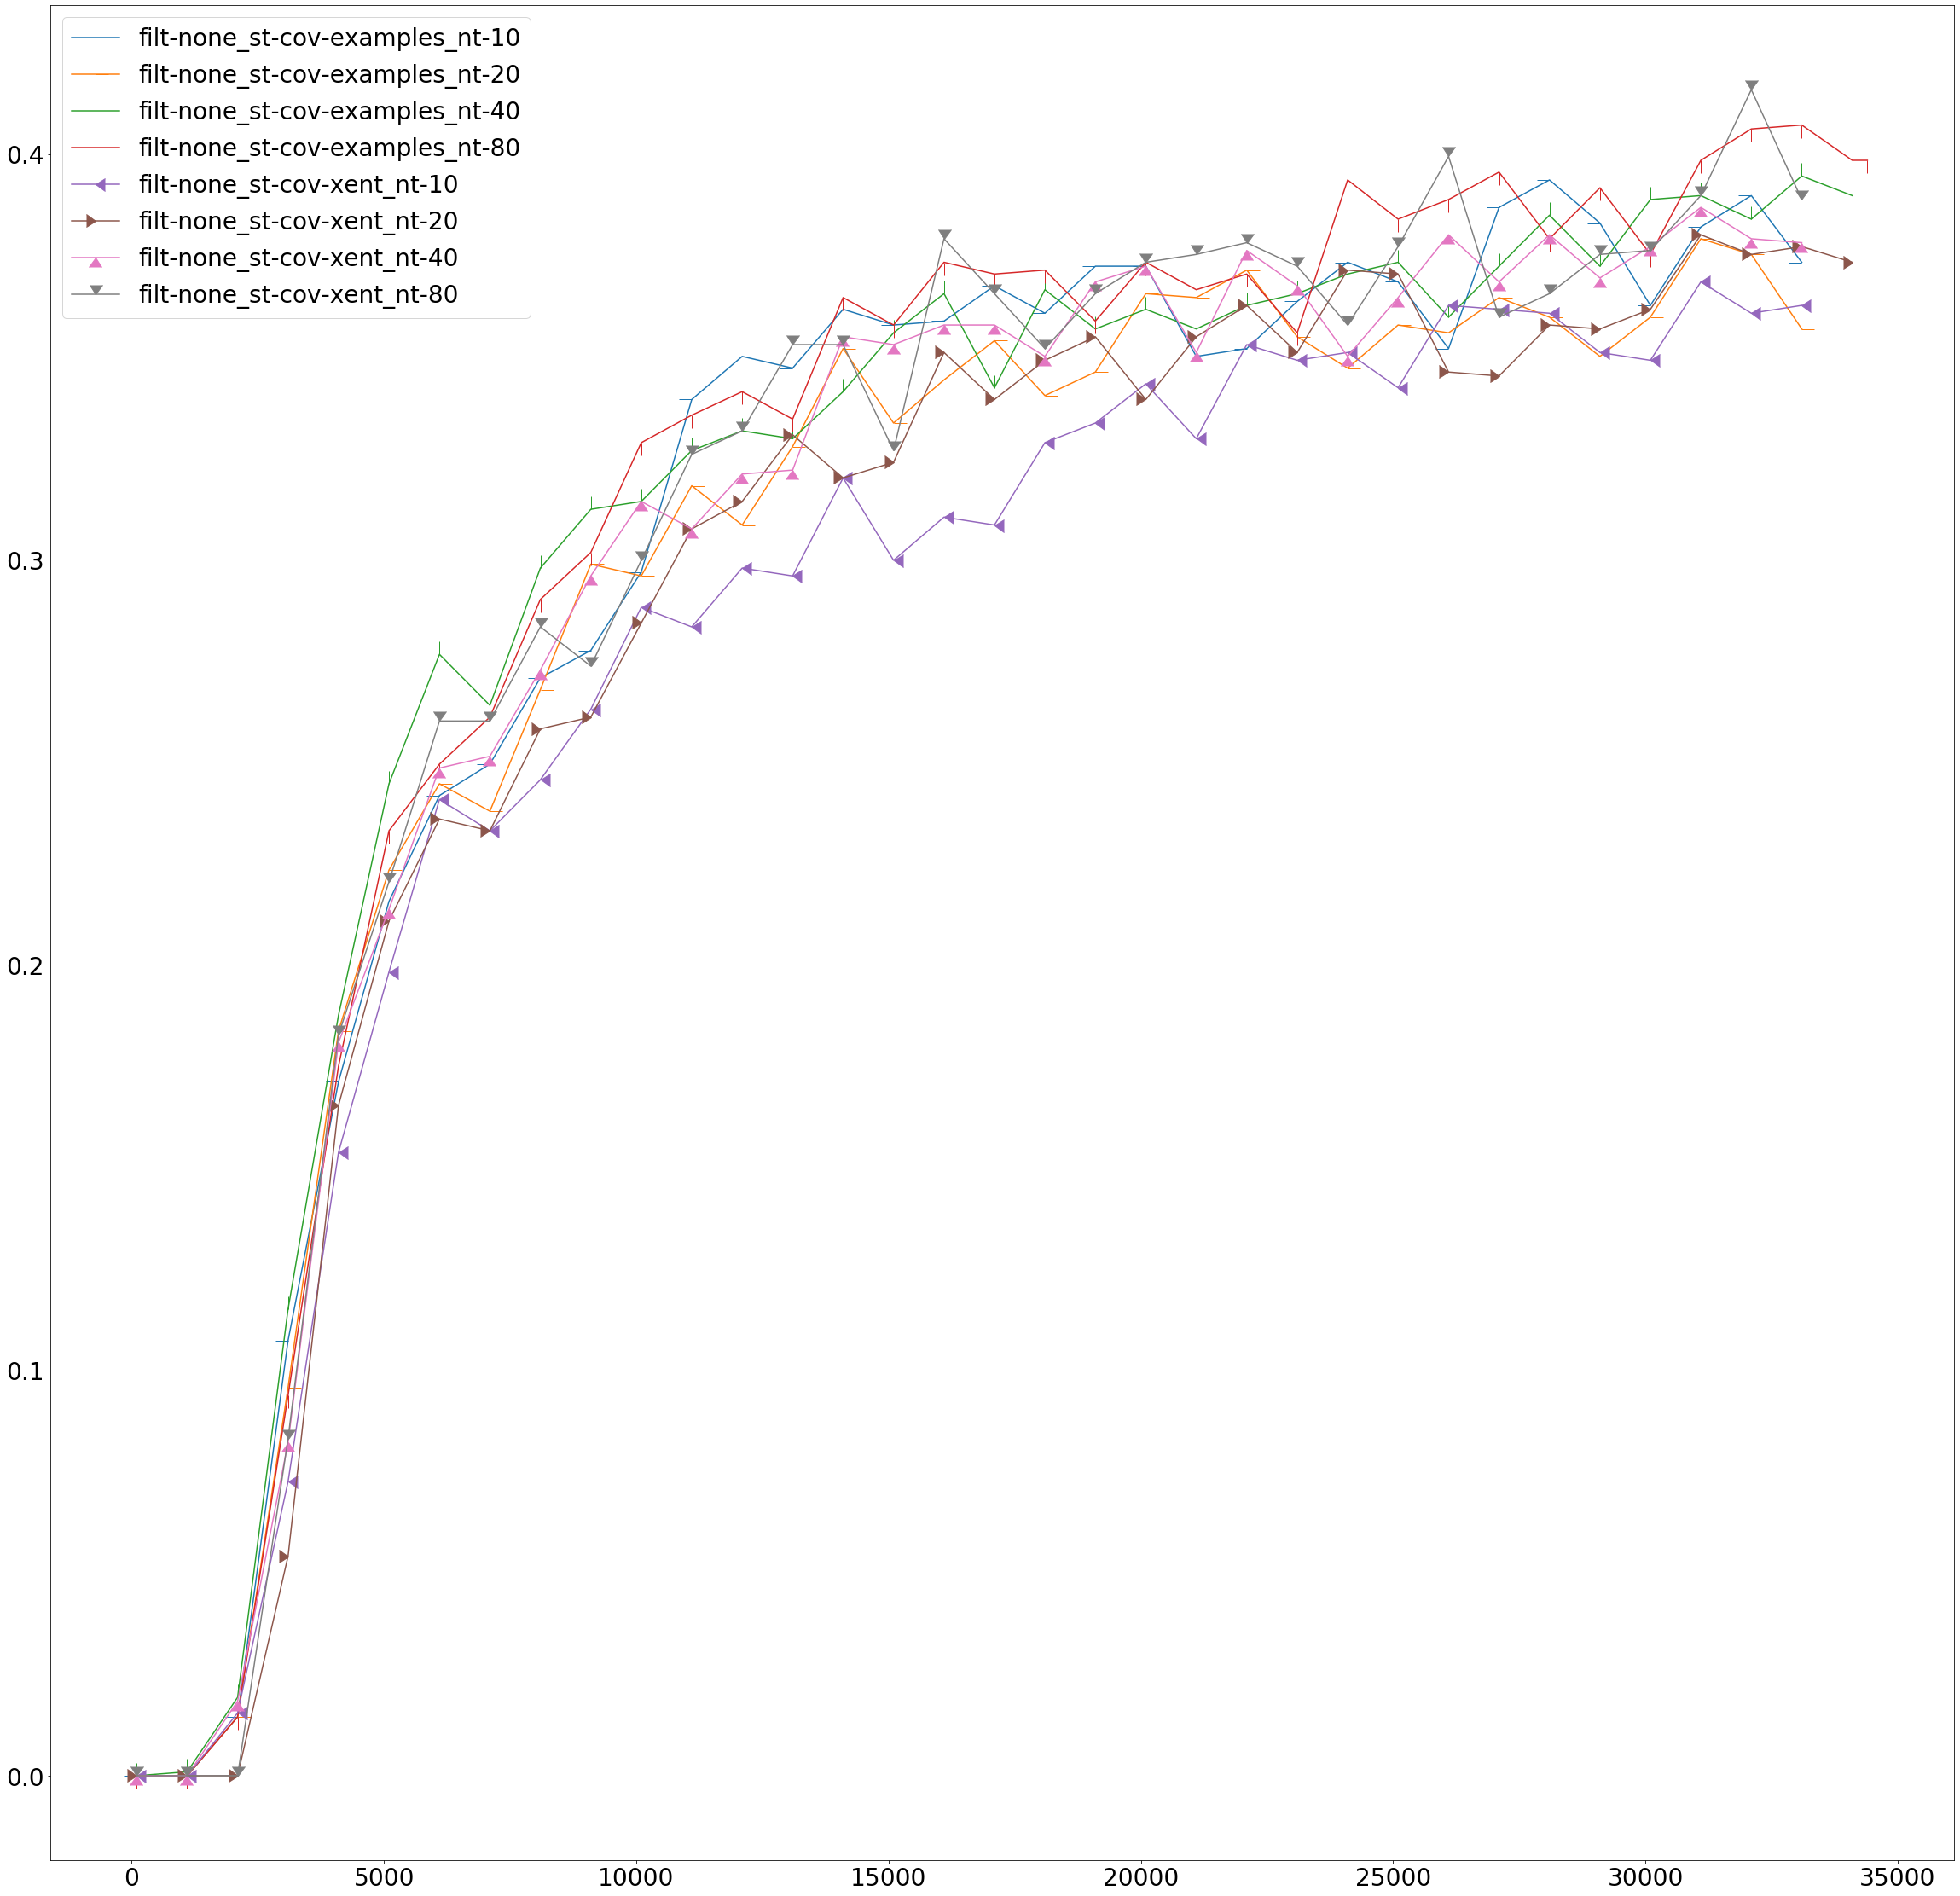

In [29]:
# See how accuracy varies over time
for i, (k, v) in enumerate(sorted(accuracy_per_run.items())):
    plt.plot(v['x'], v['all'], marker=i, label=k, ms=15)
plt.legend()